In [2]:
import os
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier, XGBRFClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import *
from xgboost import XGBClassifier
import lightgbm as lgb
import seaborn as sns
from sklearn.ensemble import *
from catboost import CatBoostClassifier
import numpy as np

In [3]:
os.chdir('..')

In [4]:
df=pd.read_csv('artifacts/data_transformation/train.csv')

In [5]:
df = df.loc[:, ~df.columns.str.startswith('NATURE')]

In [6]:
df1=df.drop(columns=['ACC_NO'])

In [7]:
x=df1.drop(columns=['3_MONTH_NPL_STATUS'])
y=df1.loc[:,['3_MONTH_NPL_STATUS']]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,stratify=y,shuffle=True)

In [9]:
#Initializing the XGB model
clf_xgb=XGBClassifier(
    scale_pos_weight=200,
    max_depth=3,
    min_child_weight=3,
    subsample=0.65,
    colsample_bytree=0.9,
    objective='binary:logistic',
    eta=0.005,
    gamma=0.1,
    n_estimators=1000 ,
     enable_categorical=True,
     eval_metric='auc',
    alpha=0.05
 )


In [10]:
params_cat = {'bagging_temperature': 0.5,
            'depth': 7,
            'l2_leaf_reg': 25,
            'learning_rate': 0.04,
            'scale_pos_weight': 150,
            'verbose': False,
            'fold_len_multiplier': 2}

clf_cat = CatBoostClassifier(**params_cat,
                               loss_function='Logloss',
                              eval_metric='AUC',
                               nan_mode='Min',
                               thread_count=8,
                               task_type='CPU')

In [11]:
clf_xgb.fit(X_train,y_train)
clf_cat.fit(X_train,y_train)

In [12]:
xgb_pred=clf_xgb.predict(X_test)
cat_pred=clf_cat.predict(X_test)

xgb_pred_proba=clf_xgb.predict_proba(X_test)[:,1]
cat_pred_proba=clf_cat.predict_proba(X_test)[:,1]

xgb_pred_70 = (xgb_pred_proba >= 0.7).astype(int)
cat_pred_70 = (cat_pred_proba >= 0.7).astype(int)

In [13]:
base_clf_predictions = np.column_stack((xgb_pred_70,cat_pred))

In [14]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'scale_pos_weight': 200,
    'learning_rate': 0.05,
    'min_child_weight': 15,
    'verbosity': -1,
    'n_estimators': 1000,
    'seed': 42
}

lgb_meta_classifier = lgb.LGBMClassifier(**params)

lgb_meta_classifier.fit(base_clf_predictions,y_test)

clf_lgb = lgb.LGBMClassifier(**params)
clf_lgb.fit(X_train,y_train)

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\p

LGBMClassifier(learning_rate=0.05, min_child_weight=15, n_estimators=1000,
               objective='binary', scale_pos_weight=200, seed=42, verbosity=-1)

In [15]:
lgb_meta_classifier.fit(base_clf_predictions,y_test)

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(learning_rate=0.05, min_child_weight=15, n_estimators=1000,
               objective='binary', scale_pos_weight=200, seed=42, verbosity=-1)

In [16]:
ensemble_predictions = lgb_meta_classifier.predict(base_clf_predictions)
ensemble_predictions_proba_70 = (lgb_meta_classifier.predict_proba(base_clf_predictions)[:,1]>= 0.7).astype(int)

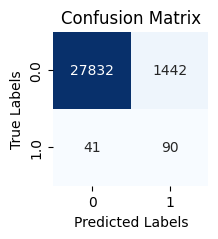

In [17]:

# NORMAL PARAMS & 0.7 THRESHOLD

conf_matrix_xgb = confusion_matrix(y_test,ensemble_predictions)
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix_xgb, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=clf_xgb.classes_, yticklabels=clf_cat.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
print('AUC: {:.2f}%'.format(roc_auc_score(y_test, ensemble_predictions) * 100))
print('F1: {:.2f}%'.format(f1_score(y_test, ensemble_predictions) * 100))
print('Precision: {:.2f}%'.format(precision_score(y_test, ensemble_predictions) * 100))
print('Recall: {:.2f}%'.format(recall_score(y_test, ensemble_predictions) * 100))
print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, ensemble_predictions) * 100))

AUC: 81.89%
F1: 10.82%
Precision: 5.87%
Recall: 68.70%
Accuracy: 94.96%


In [19]:
print(classification_report(y_test,ensemble_predictions))

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97     29274
         1.0       0.06      0.69      0.11       131

    accuracy                           0.95     29405
   macro avg       0.53      0.82      0.54     29405
weighted avg       0.99      0.95      0.97     29405



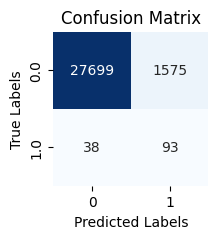

In [147]:

# NORMAL PARAMS & 0.7 THRESHOLD

conf_matrix_xgb = confusion_matrix(y_test,ensemble_predictions_proba_70)
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix_xgb, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=clf_xgb.classes_, yticklabels=clf_cat.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [151]:
print('AUC: {:.2f}%'.format(roc_auc_score(y_test, xgb_pred) * 100))
print('F1: {:.2f}%'.format(f1_score(y_test, xgb_pred) * 100))
print('Precision: {:.2f}%'.format(precision_score(y_test, xgb_pred) * 100))
print('Recall: {:.2f}%'.format(recall_score(y_test, xgb_pred) * 100))
print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, xgb_pred) * 100))

AUC: 88.22%
F1: 6.44%
Precision: 3.34%
Recall: 87.79%
Accuracy: 88.64%


In [152]:
print('AUC: {:.2f}%'.format(roc_auc_score(y_test, cat_pred) * 100))
print('F1: {:.2f}%'.format(f1_score(y_test, cat_pred) * 100))
print('Precision: {:.2f}%'.format(precision_score(y_test, cat_pred) * 100))
print('Recall: {:.2f}%'.format(recall_score(y_test, cat_pred) * 100))
print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, cat_pred) * 100))

AUC: 68.94%
F1: 20.94%
Precision: 14.33%
Recall: 38.93%
Accuracy: 98.69%


In [156]:
lgb_pred = clf_lgb.predict(X_test)

In [158]:
print('AUC: {:.2f}%'.format(roc_auc_score(y_test, lgb_pred) * 100))
print('F1: {:.2f}%'.format(f1_score(y_test, lgb_pred) * 100))
print('Precision: {:.2f}%'.format(precision_score(y_test, lgb_pred) * 100))
print('Recall: {:.2f}%'.format(recall_score(y_test, lgb_pred) * 100))
print('Accuracy: {:.2f}%'.format(accuracy_score(y_test, lgb_pred) * 100))

AUC: 59.04%
F1: 21.15%
Precision: 25.00%
Recall: 18.32%
Accuracy: 99.39%
